### 1. ResNet 모델 정의

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models

# ResNet 모델 정의
model_ResNet = models.resnet18(weights=None, num_classes=10)

### 2. 데이터셋 준비

In [2]:
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import numpy as np
from tqdm.notebook import tqdm


In [3]:
# # 평균과 표준편차 계산
# def get_mean_std(loader):
#     channels_sum, channels_squared_sum, num_batches = 0, 0, 0

#     for data, _ in loader:
#         channels_sum += torch.mean(data, dim=[0, 2, 3])
#         channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
#         num_batches += 1

#     mean = channels_sum / num_batches
#     std = (channels_squared_sum / num_batches - mean**2)**0.5
#     return mean, std

# mean, std = get_mean_std(trainloader)
# print(f"Mean: {mean}")
# print(f"Std: {std}")

NameError: name 'trainloader' is not defined

In [4]:

# 데이터셋 로드 (정규화)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # VGG는 224x224 크기의 입력
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4821, 0.4465), (0.2413, 0.2378, 0.2564))
])

# 전체 데이터셋을 로드하고 나누기
dataset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)

# # 학습시간이 길기 때문에 강의를 위해 10프로만 사용해보기
# num_samples = int(0.1 * len(dataset))
# indices = np.random.choice(len(dataset), num_samples, replace=False)
# dataset = torch.utils.data.Subset(dataset, indices)

# 학습 및 검증 데이터셋 나누기
train_len = int(0.8 * len(dataset))
val_len = len(dataset) - train_len
trainset, valset = random_split(dataset, [train_len, val_len])


# 데이터 로더 정의
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### 3. 손실 함수와 옵티마이저 정의

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ResNet.parameters(), lr=0.001)

### 4. 학습 함수 정의

In [6]:
import torchmetrics

def train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs, device):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    model = model.to(device)

    # 옵티마이저 다시 설정
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        # 모델을 학습 모드로 설정
        model.train()
        running_loss = 0.0
        train_accuracy_metric = torchmetrics.Accuracy(task='multiclass', num_classes=10, average='macro').to(device)

        # 학습 데이터에 대한 반복
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - 학습중"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # 그라디언트 초기화
            outputs = model(inputs)  # 모델을 통한 예측
            loss = criterion(outputs, labels)  # 손실 계산
            loss.backward()  # 역전파
            optimizer.step()  # 최적화 단계

            running_loss += loss.item()
            # 학습 정확도 계산
            train_accuracy_metric.update(outputs, labels)

        # 에포크의 평균 학습 손실 계산
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        train_accuracy = train_accuracy_metric.compute().item()
        train_accuracies.append(train_accuracy)

        print(f'Epoch [{epoch + 1}/{epochs}] - Training loss: {epoch_loss:.3f} / Train acc : {train_accuracy:2%}')

        # 검증 과정
        model.eval()  # 모델을 평가 모드로 설정
        running_val_loss = 0.0
        val_accuracy_metric = torchmetrics.Accuracy(task='multiclass', num_classes=10, average='macro').to(device)

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - 평가중"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                val_accuracy_metric.update(outputs, labels)


        # 에포크의 평균 검증 손실 계산
        epoch_val_loss = running_val_loss / len(val_loader)
        val_losses.append(epoch_val_loss)
        val_accuracy = val_accuracy_metric.compute().item()
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch + 1}/{epochs}] - Validation loss: {epoch_val_loss:.3f} / Val acc : {val_accuracy:2%}')

    return train_losses, val_losses, train_accuracies, val_accuracies

### 5. 테스트 함수 정의

In [7]:
def evaluate(model, loader, device):
    model.eval()
    accuracy_metric = torchmetrics.Accuracy(task='multiclass', num_classes=10, average='macro').to(device)
    with torch.no_grad():
        for data in tqdm(loader, desc=f"최종평가중"):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            # 정확도 업데이트
            accuracy_metric.update(outputs, labels)
    accuracy = accuracy_metric.compute()  # 정확도 계산
    print(f'테스트 이미지 정확도 계산: {accuracy.item() * 100:.2f}%')
    return accuracy.item()


### 6. 모델 학습

In [8]:
device = torch.device("cuda")
history = train_and_validate(model_ResNet, trainloader, valloader, optimizer, criterion, epochs=10, device=device)

Epoch 1/10 - 학습중:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch [1/10] - Training loss: 1.469 / Train acc : 46.107438%


Epoch 1/10 - 평가중:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [1/10] - Validation loss: 1.370 / Val acc : 50.885701%


Epoch 2/10 - 학습중:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch [2/10] - Training loss: 0.914 / Train acc : 67.543960%


Epoch 2/10 - 평가중:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [2/10] - Validation loss: 0.943 / Val acc : 67.428553%


Epoch 3/10 - 학습중:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch [3/10] - Training loss: 0.690 / Train acc : 75.906283%


Epoch 3/10 - 평가중:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [3/10] - Validation loss: 0.705 / Val acc : 75.411230%


Epoch 4/10 - 학습중:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch [4/10] - Training loss: 0.540 / Train acc : 81.181449%


Epoch 4/10 - 평가중:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [4/10] - Validation loss: 0.717 / Val acc : 75.682735%


Epoch 5/10 - 학습중:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch [5/10] - Training loss: 0.443 / Train acc : 84.519404%


Epoch 5/10 - 평가중:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [5/10] - Validation loss: 0.551 / Val acc : 81.399333%


Epoch 6/10 - 학습중:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch [6/10] - Training loss: 0.344 / Train acc : 87.882423%


Epoch 6/10 - 평가중:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [6/10] - Validation loss: 0.606 / Val acc : 80.127275%


Epoch 7/10 - 학습중:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch [7/10] - Training loss: 0.261 / Train acc : 90.842664%


Epoch 7/10 - 평가중:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [7/10] - Validation loss: 0.562 / Val acc : 82.124209%


Epoch 8/10 - 학습중:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch [8/10] - Training loss: 0.186 / Train acc : 93.299705%


Epoch 8/10 - 평가중:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [8/10] - Validation loss: 0.560 / Val acc : 83.098304%


Epoch 9/10 - 학습중:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch [9/10] - Training loss: 0.132 / Train acc : 95.309448%


Epoch 9/10 - 평가중:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [9/10] - Validation loss: 0.688 / Val acc : 81.359750%


Epoch 10/10 - 학습중:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch [10/10] - Training loss: 0.098 / Train acc : 96.561265%


Epoch 10/10 - 평가중:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [10/10] - Validation loss: 0.744 / Val acc : 81.272966%


### 7. 학습 과정 시각화 해보기

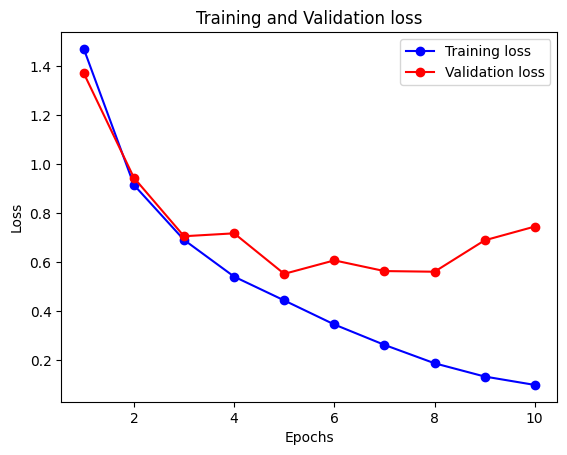

In [9]:
import matplotlib.pyplot as plt

# train_and_validate 함수로부터 손실 기록 받기
train_losses, val_losses = history[:2]

# 에포크 번호를 기준으로 그래프를 그립니다.
epochs = range(1, len(train_losses) + 1)

# 학습 및 검증 손실 그래프 그리기
plt.plot(epochs, train_losses, 'bo-', label='Training loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

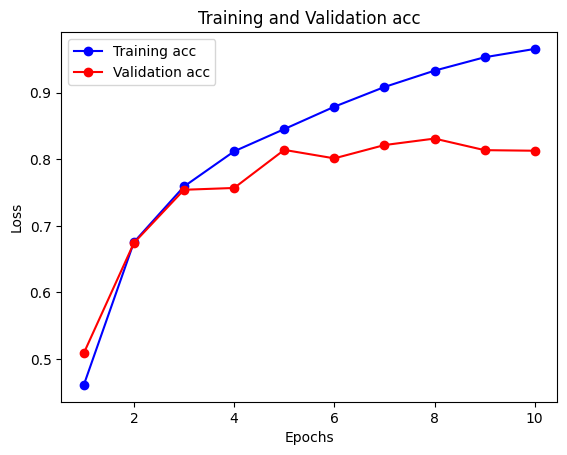

In [10]:
# train_and_validate 함수로부터 손실 기록 받기
train_accies, val_accies = history[2:]

# 에포크 번호를 기준으로 그래프를 그립니다.
epochs = range(1, len(train_losses) + 1)

# 학습 및 검증 손실 그래프 그리기
plt.plot(epochs, train_accies, 'bo-', label='Training acc')
plt.plot(epochs, val_accies, 'ro-', label='Validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 8. 최종 모델 평가 해보기

In [11]:
evaluate(model_ResNet, testloader, device)

최종평가중:   0%|          | 0/157 [00:00<?, ?it/s]

테스트 이미지 정확도 계산: 80.77%


0.8077000379562378

In [12]:
# 정규화를 원래대로 되돌리는 함수
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor
# 이미지 시각화
mean = (0.4914, 0.4821, 0.4465)
std = (0.2413, 0.2378, 0.2564)

In [14]:
# 새로운 이미지로 테스트 해보기
from PIL import Image
image_path = "./비행기.jpeg"
image = Image.open(image_path)
image = transform(image).unsqueeze(0)  # 배치 차원을 추가합니다.
model_ResNet.eval()
image = image.to(device)
outputs = model_ResNet(image)
_, pred = torch.max(outputs, 1)
print("예측결과 : ", classes[pred])

예측결과 :  plane
